In [1]:
import numpy as np
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random
import tqdm 

%matplotlib inline

In [2]:
root = "../datasets/baganza/"
minis =  os.listdir(root)
minis = [x for x in sorted(minis) if x.startswith("mini-")]
data = None

minis = minis[:2]

for mini in tqdm.tqdm(minis):
    d = np.load(root + mini)
    d.resize(1, d.shape[0], d.shape[1], d.shape[2])
    d[d > 10e5] = 0
    
    if data is None: data = d
    else: data = np.concatenate((data, d))

100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


Text(0.5, 1.0, 'Average DEP')

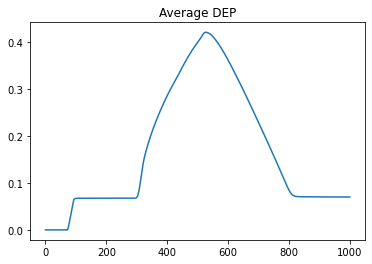

In [8]:
plt.plot(range(1000), [np.mean(x) for x in data[0]])
plt.title("Average DEP")

In [3]:
indices = [(300, 800), (300, 800), (390, 900), (300, 800), (390, 900), (390, 850), (350, 800), (350, 900)]
dataset = []
for i, d in enumerate(data):
     dataset.append(d[indices[i][0]:indices[i][1]])

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [20]:
if torch.cuda.is_available():  
  dev = "cuda:0"
else:
  dev = "cpu"

device = torch.device(dev)

In [172]:
class CNNet(torch.nn.Module):
    
    def __init__(self):
        super(CNNet, self).__init__()
        
        # [batch * channel(# of channels of each image) * depth(# of frames) * height * width]
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool3d(kernel_size=2)
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool3d(kernel_size=2)
        
        self.deconv1 = nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        return x

net = CNNet().to(device)

In [173]:
import torch.optim as optim
from torchvision import transforms, utils

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [174]:
dataset[0].shape

(500, 256, 256)

In [184]:
losses = []
epochs = 2

past_frames = 10
future_frames = 8

for epoch in range(2):
    
    epoch_loss = []
    
    for i in range(len(dataset[0]) - past_frames - future_frames):
        
        # [batch * channel(# of channels of each image) * depth(# of frames) * height * width]

        x = dataset[0][i:i + past_frames]
        x = torch.FloatTensor(x).expand(1, 1, -1, -1, -1).to(device)
        
        y = dataset[0][i + past_frames:i + past_frames + future_frames]
        y = torch.FloatTensor(y).expand(1, 1, -1, -1, -1).to(device)

        #sample = torch.FloatTensor(in_x).to(device)
        #y = torch.FloatTensor(out_x).flatten().to(device)

        # Compute
        y_hat = net(
            x
        ).to(device)

        # Loss
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        print("Loss {}".format(loss.item()))

    avg = np.asarray(epoch_loss).mean()
    losses.append(avg)
    print("Epoch {} - avg.loss: {}".format(epoch, avg))

Loss 0.11309884488582611
Loss 0.0998082160949707
Loss 0.08636477589607239
Loss 0.07492600381374359
Loss 0.0669182538986206
Loss 0.06300608813762665
Loss 0.06328588724136353
Loss 0.06729626655578613
Loss 0.07439849525690079
Loss 0.08400967717170715
Loss 0.09559723734855652
Loss 0.10870669782161713
Loss 0.12279210984706879
Loss 0.13735774159431458
Loss 0.15191788971424103
Loss 0.16619455814361572
Loss 0.17995214462280273
Loss 0.19278918206691742
Loss 0.20399656891822815
Loss 0.21396386623382568
Loss 0.2231752872467041
Loss 0.2318190038204193
Loss 0.2400413602590561
Loss 0.24798160791397095
Loss 0.25565963983535767
Loss 0.2631394863128662
Loss 0.2704524099826813
Loss 0.2775830030441284
Loss 0.284490168094635
Loss 0.2911497950553894
Loss 0.2975579798221588
Loss 0.3037317097187042
Loss 0.30972447991371155
Loss 0.31561699509620667
Loss 0.3214784264564514
Loss 0.32732534408569336
Loss 0.3332131505012512
Loss 0.33916470408439636
Loss 0.34514766931533813
Loss 0.3511987626552582
Loss 0.357127845

KeyboardInterrupt: 